In [42]:
# Import pandas, numpy, and matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# seaborn is a data visualization library built on matplotlib
import seaborn as sns

from scipy import stats

# set the plotting style
sns.set_style("whitegrid") 

# Rainfall Comparison: Seattle, WA vs. Charlotte, NC

## Introduction

##### This analysis that answers the question: `Does it rain more in Seattle, WA than in Charlotte, NC?
##### The ultimate goal of this project is to use precipitation data from 2018–2022 to determine whether Seattle experiences more rainfall than Charlotte, or vice versa. By analyzing yearly and daily/monthly/yearly averages, the frequency of rainy days, and the distribution of precipitation intensity, the analysis aims to provide clear insights into how precipitation patterns help answer the question of whether Seattle rain more than Charlotte.

## Load the Weahter Data

##### Load the Seattle Data set

In [43]:
df_seattle = pd.read_csv(
    'https://raw.githubusercontent.com/alexsong-lab/DATA5100/refs/heads/main/weather/data/seattle_rain.csv'
)

In [44]:
type(df_seattle)

pandas.core.frame.DataFrame

##### Load the Charlotte Data set

In [45]:
df_clt = pd.read_csv(
    'https://raw.githubusercontent.com/alexsong-lab/DATA5100/refs/heads/main/weather/data/clt_rain.csv'
)

In [46]:
type(df_clt)

pandas.core.frame.DataFrame

In [47]:
df_clt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   STATION  1826 non-null   object 
 1   NAME     1826 non-null   object 
 2   DATE     1826 non-null   object 
 3   PRCP     1826 non-null   float64
 4   SNOW     1826 non-null   float64
 5   SNWD     1826 non-null   float64
dtypes: float64(3), object(3)
memory usage: 85.7+ KB


## Clean Data sets

##### Convert `DATE` to datetime for both cities' data set.

In [48]:
df_seattle['DATE'] = pd.to_datetime(df_seattle['DATE'])

C:\Users\alexm\AppData\Local\Temp\ipykernel_20712\3087519436.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_seattle['DATE'] = pd.to_datetime(df_seattle['DATE'])


In [49]:
df_clt['DATE'] = pd.to_datetime(df_clt['DATE'])

In [50]:
df_clt['DATE'].agg(['min', 'max'])

min   2018-01-01
max   2022-12-31
Name: DATE, dtype: datetime64[ns]

##### Join data frames keeping `DATE` and `PRCP` columns

In [51]:
df = df_clt[['DATE', 'PRCP']].merge(df_seattle[['DATE', 'PRCP']], on='DATE', how='outer')

##### Create a tidy data frame with columns for city and precipitation

In [52]:
df = pd.melt(df, id_vars='DATE', var_name='city', value_name='precipitation')

##### After Join, rename columns or values `CLT` and `SEA`

In [53]:
df.loc[df['city'] == 'PRCP_x', 'city'] = 'CLT'

In [54]:
df.loc[df['city'] == 'PRCP_y', 'city'] = 'SEA'

##### Rename the columns to be lowercase using `df.rename()`

In [55]:
df = df.rename(columns={'DATE': 'date'})

### Impute missing values

##### Define a column that labels each day by the day of the year: 1, 2, ..., 365.

In [56]:
df['day_of_year'] = pd.DatetimeIndex(df['date']).day_of_year

##### Compute the mean precipitation for each day in Seattle, averaged across years.

In [57]:
mean_day_precipitation = df.loc[
    df['city'] == 'SEA',
    ['precipitation', 'day_of_year']
].groupby(
    'day_of_year'
).mean()

##### Get the index of each row where precipitation is missing.

In [58]:
indices = np.where(df['precipitation'].isna() == True)[0]

##### Replace each missing value with the mean on that day

In [59]:
for index in indices:
    df.loc[index, 'precipitation'] = mean_day_precipitation.loc[df.loc[index,'day_of_year']].values[0]

## Export the clean .csv file to current working directory

In [60]:
df.to_csv('clean_weather_data.csv', encoding='utf-8-sig', index=False)

## Add additional variables to the data

##### Any_precipitaion, month names, season names, and year

In [61]:
df['any_precipitation'] = df['precipitation'] > 0

In [62]:
df['month'] = pd.DatetimeIndex(df['date']).month

import calendar
month_names = list(calendar.month_name[1:]) 

In [63]:
df.loc[df['month'].isin([3,4,5]), 'season'] = 'Spring'
df.loc[df['month'].isin([6,7,8]), 'season'] = 'Summer'
df.loc[df['month'].isin([9,10,11]), 'season'] = 'Fall'
df.loc[df['month'].isin([12,1,2]), 'season'] = 'Winter'

In [64]:
df['year'] = df['date'].dt.year

## Weather Data Analysis

##### Mean Daily Precipitation

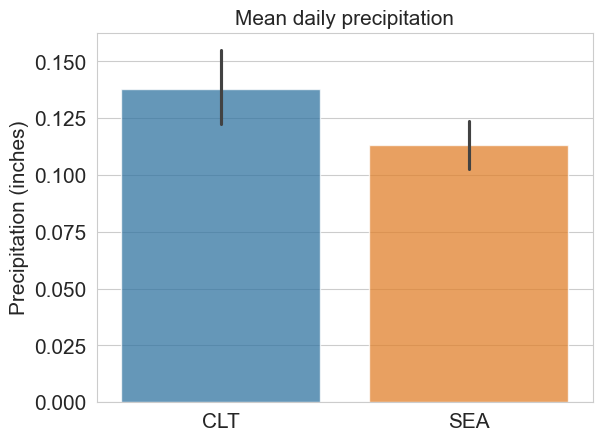

In [65]:
sns.barplot(data=df, x='city', y='precipitation', hue='city', alpha=0.75)

plt.xlabel(None)
plt.ylabel('Precipitation (inches)', fontsize=15)
plt.title('Mean daily precipitation', fontsize=15)

plt.tick_params(labelsize=15)

plt.show()

##### Mean monthly precipitation

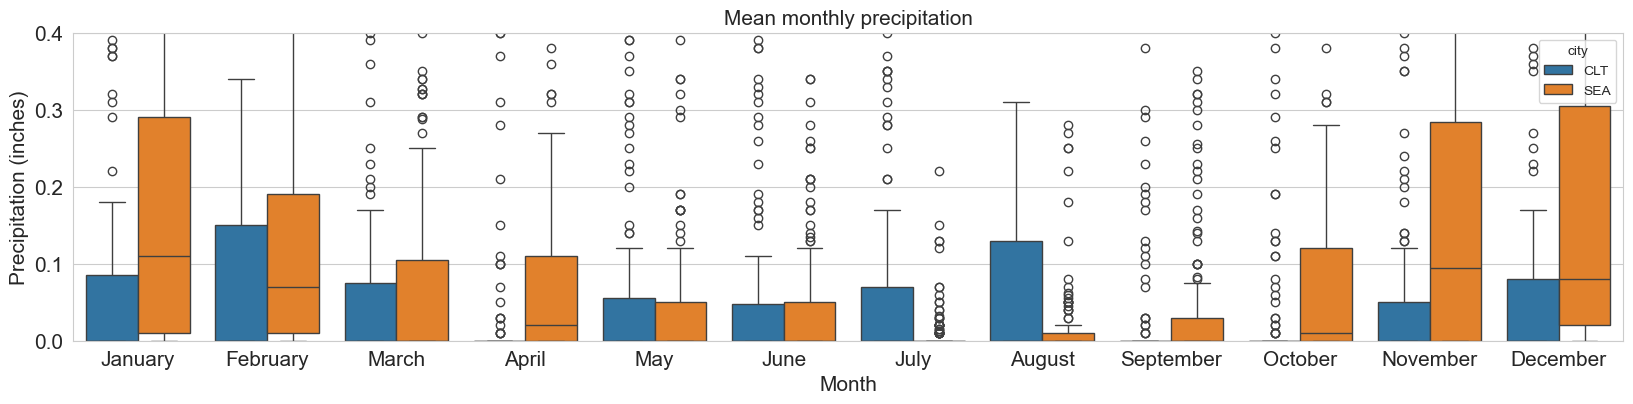

In [66]:
plt.figure(figsize=(20, 4))

sns.boxplot(data=df, x='month', y='precipitation', hue='city')

plt.xlabel('Month', fontsize=15)
plt.ylabel('Precipitation (inches)', fontsize=15)
plt.title('Mean monthly precipitation', fontsize=15)

plt.tick_params(labelsize=15)

plt.xticks(ticks=range(12), labels=month_names)

plt.ylim(0, 0.4)

plt.show()

##### T-test: how much rain fell i.e. volume

In [67]:
significance_level = 0.05
significantly_different = np.zeros(12)

# Perform t-test for each month
for month in range(1, 13):
    # Get precipitation data for Seattle and St. Louis for the current month
    sea_data = df.loc[(df['city'] == 'SEA') & (df['month'] == month), 'precipitation']
    clt_data = df.loc[(df['city'] == 'CLT') & (df['month'] == month), 'precipitation']

    t_statistic, p_value = stats.ttest_ind(sea_data, clt_data, equal_var=False)

    if p_value < significance_level:
        significantly_different[month-1] = 1

    print(f"Month {month}:")
    print(f"  t-statistic = {t_statistic:.2f}")
    print(f"  p-value t test = {p_value:.3f}")
    print("-" * 20)

Month 1:
  t-statistic = 2.82
  p-value t test = 0.005
--------------------
Month 2:
  t-statistic = 0.41
  p-value t test = 0.683
--------------------
Month 3:
  t-statistic = -1.73
  p-value t test = 0.084
--------------------
Month 4:
  t-statistic = -1.32
  p-value t test = 0.187
--------------------
Month 5:
  t-statistic = -1.64
  p-value t test = 0.102
--------------------
Month 6:
  t-statistic = -1.59
  p-value t test = 0.113
--------------------
Month 7:
  t-statistic = -4.37
  p-value t test = 0.000
--------------------
Month 8:
  t-statistic = -4.99
  p-value t test = 0.000
--------------------
Month 9:
  t-statistic = -2.10
  p-value t test = 0.037
--------------------
Month 10:
  t-statistic = -0.22
  p-value t test = 0.826
--------------------
Month 11:
  t-statistic = 1.11
  p-value t test = 0.267
--------------------
Month 12:
  t-statistic = 2.07
  p-value t test = 0.039
--------------------


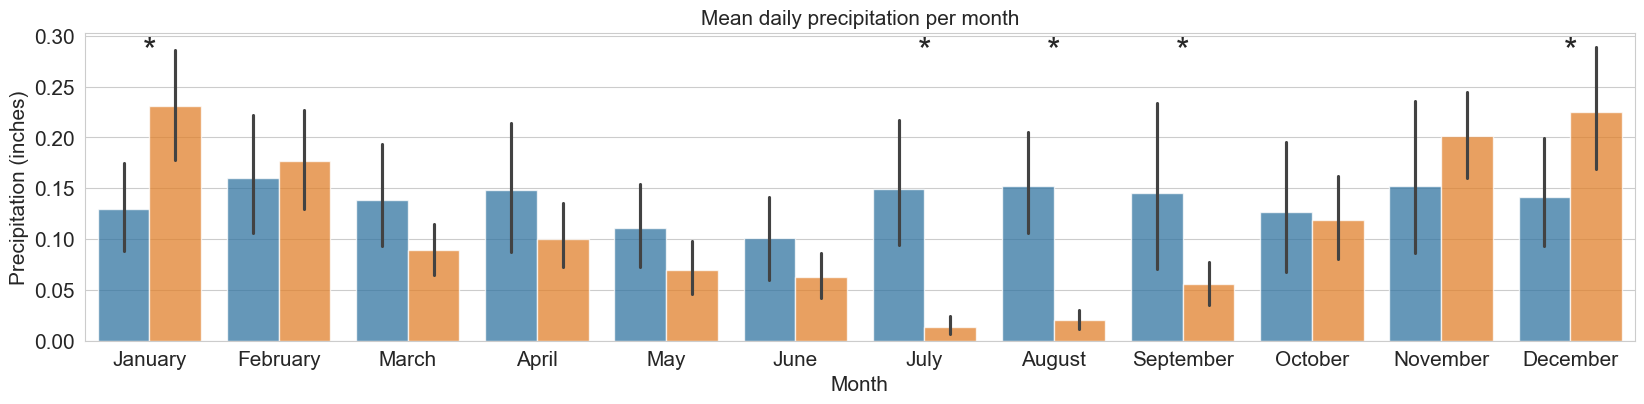

In [68]:
plt.figure(figsize=(20, 4))

sns.barplot(data=df, x='month', y='precipitation', hue='city', alpha=0.75, legend=False)

plt.xlabel('Month', fontsize=15)
plt.ylabel('Precipitation (inches)', fontsize=15)
plt.title('Mean daily precipitation per month', fontsize=15)

plt.tick_params(labelsize=15)

plt.xticks(ticks=range(12), labels=month_names)



# Add stars for significantly different months
for month in range(12):
    if significantly_different[month] == 1:

        # Add a star
        plt.text(month, 0.275, '*', ha='center', fontsize=25)

plt.show()

##### Z-test: how often it rained i.e. frequency

In [69]:
from statsmodels.stats.proportion import proportions_ztest

significance_level = 0.05
significantly_different_proportion = np.zeros(12)

# Perform z-test for each month
for month in range(1, 13):

    # Create a contingency table for Seattle and St. Louis for the current month:
    contingency_table = pd.crosstab(
        df.loc[df['month'] == month, 'city'], df.loc[df['month'] == month, 'any_precipitation']
    )

    # Calculate the number of True values (days with precipitation) for each city
    days_with_precipitation = contingency_table[True]

    # Calculate the total number of days for each city
    total_counts = contingency_table.sum(axis=1)

    # Hypothesis test
    zstat, p_value = proportions_ztest(
        count=days_with_precipitation, nobs=total_counts, alternative='two-sided'
    )

    if p_value < significance_level:
        significantly_different_proportion[month-1] = 1

    print(f"Month {month}:")
    print(f"  z-statistic = {zstat:.2f}")
    print(f"  p-value = {p_value:.3f}")
    print("-" * 20)

Month 1:
  z-statistic = -7.00
  p-value = 0.000
--------------------
Month 2:
  z-statistic = -6.64
  p-value = 0.000
--------------------
Month 3:
  z-statistic = -2.77
  p-value = 0.006
--------------------
Month 4:
  z-statistic = -6.30
  p-value = 0.000
--------------------
Month 5:
  z-statistic = -1.96
  p-value = 0.050
--------------------
Month 6:
  z-statistic = -1.53
  p-value = 0.125
--------------------
Month 7:
  z-statistic = 2.47
  p-value = 0.013
--------------------
Month 8:
  z-statistic = 2.49
  p-value = 0.013
--------------------
Month 9:
  z-statistic = -2.62
  p-value = 0.009
--------------------
Month 10:
  z-statistic = -5.35
  p-value = 0.000
--------------------
Month 11:
  z-statistic = -7.39
  p-value = 0.000
--------------------
Month 12:
  z-statistic = -8.96
  p-value = 0.000
--------------------


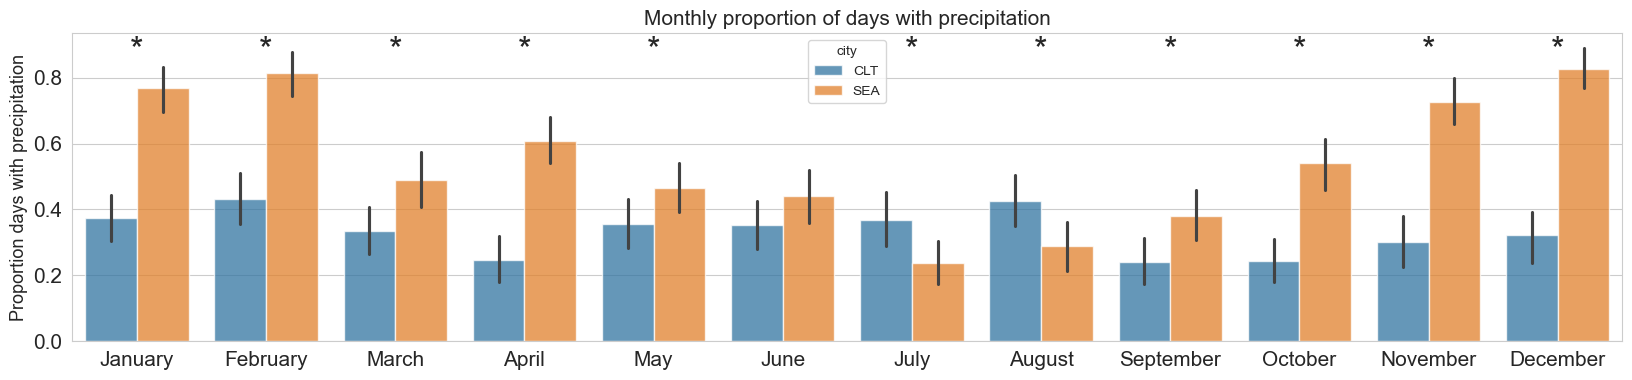

In [70]:
plt.figure(figsize=(20, 4))

sns.barplot(data=df, x='month', y='any_precipitation', hue='city', alpha=0.75)

plt.xlabel(None)
plt.ylabel('Proportion days with precipitation', fontsize=13)
plt.title('Monthly proportion of days with precipitation', fontsize=15)

plt.xticks(ticks=range(12), labels=month_names)
plt.tick_params(labelsize=15)

# Add stars for significantly different months
for month in range(12):
    if significantly_different_proportion[month] == 1:

        # Add a star
        plt.text(month, .85, '*', ha='center', fontsize=25)

plt.show()

##### Mean proportion of days with any precipitation per season

In [71]:
season_order = ['Spring','Summer','Fall','Winter']

# Seasonal Precipitation Percentage
seasonal_prcp_perc = df.groupby(['city','season'])['any_precipitation'].mean().reset_index()

seasonal_prcp_perc = (seasonal_prcp_perc.set_index('season').loc[season_order].reset_index())

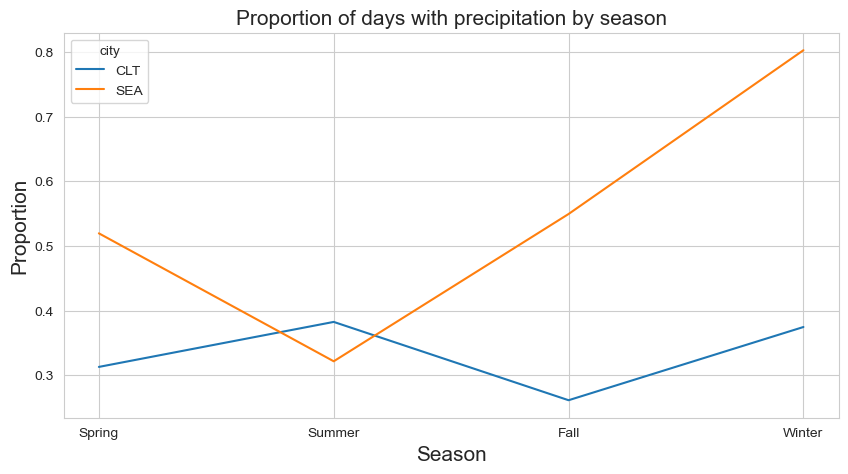

In [72]:
# Mean proportion of days with any precipitaion for each season
plt.figure(figsize=(10,5))
sns.lineplot(data=seasonal_prcp_perc, x='season', y='any_precipitation', hue='city')

plt.xlabel('Season', fontsize=15)
plt.ylabel('Proportion', fontsize=15)
plt.title('Proportion of days with precipitation by season', fontsize=15)

plt.show()

##### Annual mean and total precipitation by year

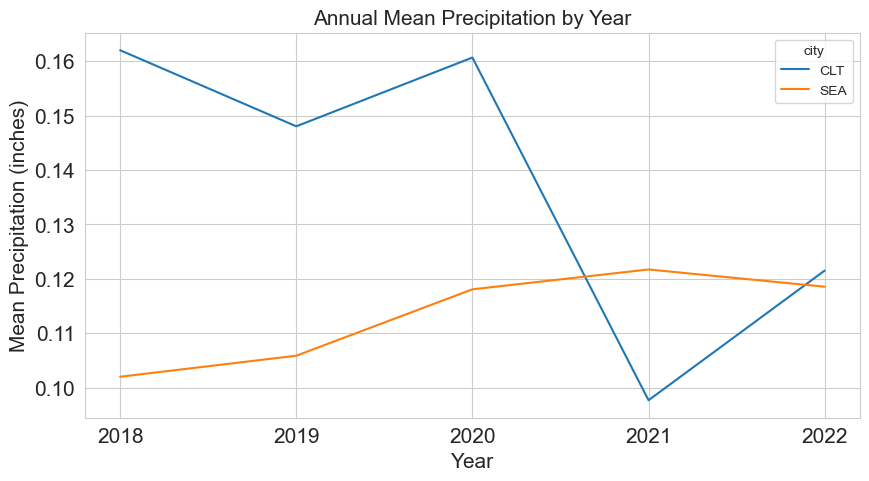

In [73]:
#Annual mean precipation by year (2018-2022)
annual_mean = df.groupby(['city', 'year'])['precipitation'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=annual_mean, x='year', y='precipitation', hue='city')

plt.xlabel('Year', fontsize=15)
plt.ylabel('Mean Precipitation (inches)', fontsize=15)
plt.title('Annual Mean Precipitation by Year', fontsize=15)

plt.xticks(sorted(annual_mean['year'].unique()))
plt.tick_params(labelsize=15)

plt.show()

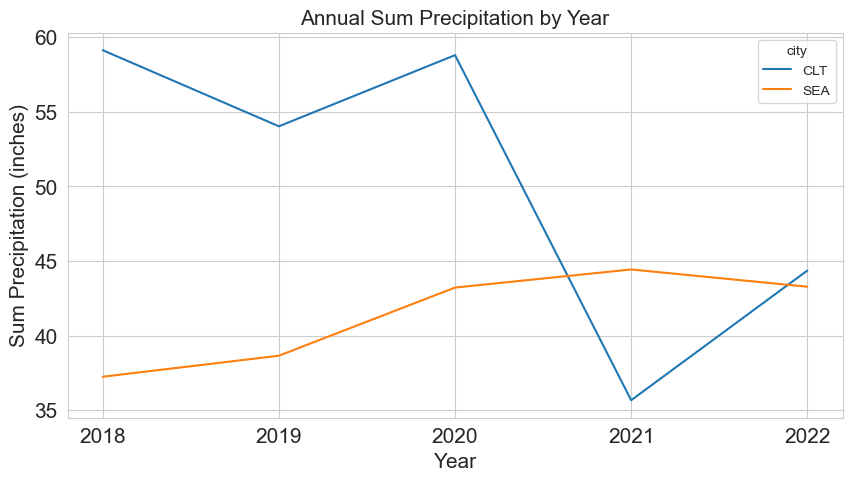

In [74]:
#Annual mean precipation by year (2018-2022)
annual_sum = df.groupby(['city', 'year'])['precipitation'].sum().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=annual_sum, x='year', y='precipitation', hue='city')

plt.xlabel('Year', fontsize=15)
plt.ylabel('Sum Precipitation (inches)', fontsize=15)
plt.title('Annual Sum Precipitation by Year', fontsize=15)

plt.xticks(sorted(annual_sum['year'].unique()))
plt.tick_params(labelsize=15)

plt.show()